<a href="https://colab.research.google.com/github/Aisha-Hagar/Machine_Learning/blob/main/IoT_Botnet_Attack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

## **Install and import required packages**

In [ ]:
!pip install kafka-python

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from numpy import nan, inf
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [ ]:
import time

# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer

## **Load the data**

In [ ]:
iot_static_data = pd.read_csv("iot_static_data.csv") 
print(iot_static_data.info())
print("Labels are: ",iot_static_data.Class.unique())
print('Number of samples in each class = \n', iot_static_data.Class.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25609 entries, 0 to 25608
Columns: 117 entries, MI_dir_L5_weight to Class
dtypes: float64(115), object(2)
memory usage: 22.9+ MB
None
Labels are:  ['BENIGN' 'mirai_udp_attack' 'mirai_ack_attack' 'gafgyt_scan_attack'
 'mirai_scan_attack' 'gafgyt_tcp_attack' 'gafgyt_udp_attack'
 'gafgyt_junk_attack' 'gafgyt_combo_attack' 'mirai_syn_attack'
 'mirai_udpplain_attack']
Number of samples in each class = 
 BENIGN                   22287
mirai_udp_attack          1774
gafgyt_udp_attack          446
gafgyt_junk_attack         377
gafgyt_tcp_attack          213
gafgyt_scan_attack         200
mirai_syn_attack           101
mirai_ack_attack            96
mirai_scan_attack           86
gafgyt_combo_attack         18
mirai_udpplain_attack       11
Name: Class, dtype: int64


Seperate the features and the labels.

In [ ]:
X = iot_static_data.drop(columns=['Class'])
y = iot_static_data['Class']

# **Static Solution**

Split the data to train and test with ratio 7:3.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.describe()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,...,HH_jit_L0.1_mean,HH_jit_L0.1_variance,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
count,17926.000000,17926.000000,1.792600e+04,17926.000000,17926.000000,1.792600e+04,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,1.792600e+04,17926.000000,17926.000000,1.792600e+04,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,1.792600e+04,1.792600e+04,17926.000000,17926.000000,17926.000000,1.792600e+04,...,1.792600e+04,1.792600e+04,17926.000000,1.792600e+04,1.792600e+04,17926.000000,17926.000000,1.792600e+04,17926.000000,1.792600e+04,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,1.792600e+04,17926.000000,1.792600e+04,1.792600e+04,17926.000000,17926.000000,17926.000000,17926.000000,17926.000000,1.792600e+04,1.792600e+04,1.792600e+04,17926.000000,17926.000000,1.792600e+04,17926.000000,1.792600e+04,1.792600e+04,1.792600e+04
mean,16.317811,137.678378,7.564287e+03,24.518091,137.708672,8.066751e+03,63.907386,138.481453,8989.765236,553.503863,141.454163,13122.001820,3522.589622,140.567918,15748.416568,16.317811,137.678378,7.564287e+03,24.518091,137.708672,8.066751e+03,63.907387,138.481456,8989.765295,553.503993,141.455573,13122.022089,3522.591180,140.572393,15748.435140,10.107872,138.302670,18.325340,192.503540,1.420873e+04,-8.145414e+02,-0.002858,14.907631,138.307184,1.898075e+01,...,9.194282e+07,4.435333e+15,1664.485695,9.362682e+07,6.061879e+15,1.773172,139.967778,1.528697e+01,183.460821,7.401100e+03,863.143572,0.016637,1.974088,140.128794,15.838145,183.537496,7747.262284,872.672450,0.017144,2.529040,140.157387,1.670429e+01,183.391316,8.155801e+03,8.810811e+02,0.016431,4.782361,139.598382,20.404768,181.595918,9.361082e+03,8.677917e+02,1.765570e-02,17.142778,138.285070,2.284264e+01,180.626367,1.112307e+04,8.715709e+02,2.785289e-02
std,41.020928,129.909999,2.608109e+04,64.919051,126.981410,2.632952e+04,184.226018,122.668416,25792.736460,1699.912209,110.843011,27759.441565,11849.753873,106.295413,26092.399794,41.020928,129.909999,2.608109e+04,64.919051,126.981410,2.632952e+04,184.226018,122.668421,25792.736440,1699.912167,110.845387,27759.432053,11849.753410,106.303456,26092.388625,29.688244,143.309607,60.969599,177.021962,5.836225e+04,7.324647e+03,0.115811,47.232452,142.268074,6.110375e+01,...,3.545149e+08,4.333013e+16,6809.224372,3.553667e+08,4.998442e+16,8.191093,148.883530,5.985077e+01,176.418346,3.920033e+04,5504.246796,0.113177,10.778915,147.548565,61.296886,175.579181,40852.981139,5639.090714,0.120880,17.709794,145.507282,6.287256e+01,174.262714,4.292472e+04,5.855418e+03,0.137925,61.753409,1

## **Data Preprocessing**

### **Feature extraction**

Get columns with constant value.

In [ ]:
const = list((X_train.columns[X_train.nunique() <= 1]).values)
print(const)

[]


Check if columns contain null or infinite values.

In [ ]:
print(X_train.isnull().values.any())
print(X_train.isin([np.inf, -np.inf]).values.any())

False
False


Get highly correlated features and drop them because they are considered redundant features.

Reference: https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/

In [ ]:
correlated_features = set()
correlation_matrix = X_train.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print('Number of correlated features = ', len(correlated_features))
print(correlated_features)
X_train.drop(labels=correlated_features, axis=1, inplace=True)

Number of correlated features =  94
{'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L5_variance', 'HH_L1_weight', 'HH_L5_weight', 'HpHp_L1_pcc', 'HH_jit_L3_weight', 'HpHp_L3_weight', 'HpHp_L3_mean', 'H_L0.1_variance', 'H_L1_mean', 'HH_jit_L1_weight', 'HpHp_L0.01_weight', 'H_L1_weight', 'HH_L3_covariance', 'HH_L0.01_weight', 'HH_L0.01_std', 'HpHp_L0.01_std', 'HH_jit_L0.1_mean', 'MI_dir_L3_weight', 'HH_L1_covariance', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L0.1_mean', 'HH_jit_L3_variance', 'H_L3_variance', 'MI_dir_L0.01_weight', 'MI_dir_L3_variance', 'HH_L0.1_weight', 'HpHp_L3_radius', 'HpHp_L0.1_mean', 'HpHp_L5_std', 'H_L5_weight', 'HpHp_L1_mean', 'HH_jit_L1_variance', 'MI_dir_L0.1_weight', 'HH_L3_std', 'HpHp_L3_pcc', 'H_L3_weight', 'HpHp_L1_radius', 'HpHp_L0.01_mean', 'HpHp_L1_covariance', 'HpHp_L5_pcc', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L0.01_radius', 'HpHp_L3_magnitude', 'HH_jit_L0.01_variance', 'H_L0.01_weight', 'H_L5_mean', 'HpHp_L0.01_pcc', 'HH_L3_weight', 'H_L1_variance', 'HpHp_L1

Get categorical features.

In [ ]:
X_train.select_dtypes(include='object')

,Source
11752,Philips B120N10 Baby Monitor
23951,Philips B120N10 Baby Monitor
821,Philips B120N10 Baby Monitor
20467,Samsung SNH 1011 N Webcam
11890,SimpleHome XCS7 1002 WHT Security Camera
...,...
21575,Provision PT 838 Security Camera
5390,Danmini Doorbell
860,Provision PT 737E Security Camera
15795,SimpleHome XCS7 1002 WHT Security Camera


### **One-hot encoding**

One-hot encode categorical features and set the one-hot encoder to ignore unknown categorical features encountered in the test data. 

In [ ]:
objcols = X_train.select_dtypes(['object']).columns
print(objcols)

enc = OneHotEncoder(handle_unknown = 'ignore')

for obj in objcols:
    X_train[obj] = X_train[obj].astype('category')

X_cat = enc.fit_transform(X_train[list(objcols.values)]).toarray()

Index(['Source'], dtype='object')


In [ ]:
X_ = X_train.drop(labels=list(objcols.values), axis=1).to_numpy()
X_train = np.hstack((X_,X_cat))
print(X_train.shape)

(17926, 30)


## **Training phase**

The model used is Random Forest classifier.

In [ ]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00     15618
  gafgyt_combo_attack       1.00      1.00      1.00        13
   gafgyt_junk_attack       1.00      1.00      1.00       282
   gafgyt_scan_attack       1.00      1.00      1.00       138
    gafgyt_tcp_attack       1.00      0.97      0.99       145
    gafgyt_udp_attack       0.99      1.00      0.99       321
     mirai_ack_attack       1.00      1.00      1.00        68
    mirai_scan_attack       1.00      1.00      1.00        55
     mirai_syn_attack       1.00      1.00      1.00        67
     mirai_udp_attack       1.00      1.00      1.00      1209
mirai_udpplain_attack       1.00      1.00      1.00        10

             accuracy                           1.00     17926
            macro avg       1.00      1.00      1.00     17926
         weighted avg       1.00      1.00      1.00     17926

[[15618     0     0     0     0     0     0     0   

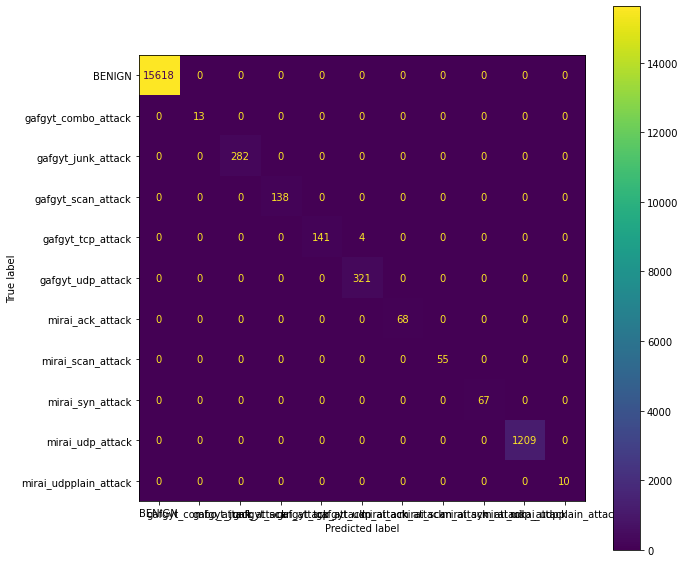

In [ ]:
y_train_pred = rf_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred, labels=rf_clf.classes_)
print(cm)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(cm ,display_labels=rf_clf.classes_)
disp.plot(ax=ax)
plt.show()

## **Test and Evaluation phases**

1. Drop the columns determined in the preprocessing phase.

2. One-hot encode categorical features.

3. Predict the test dataset.

4. Print the classification report.

5. Plot the confusion matrix.

In [ ]:
X_test = X_test.drop(labels=correlated_features, axis=1)
for obj in objcols.values:
    X_test[obj] = X_test[obj].astype('category')
x_cat = enc.transform(X_test[list(objcols.values)]).toarray()
x_ = X_test.drop(labels=list(objcols.values), axis=1).to_numpy()
X_test = np.hstack((x_,x_cat))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      6669
  gafgyt_combo_attack       0.00      0.00      0.00         5
   gafgyt_junk_attack       0.96      1.00      0.98        95
   gafgyt_scan_attack       1.00      0.95      0.98        62
    gafgyt_tcp_attack       1.00      0.99      0.99        68
    gafgyt_udp_attack       0.99      1.00      1.00       125
     mirai_ack_attack       0.96      0.96      0.96        28
    mirai_scan_attack       1.00      1.00      1.00        31
     mirai_syn_attack       1.00      1.00      1.00        34
     mirai_udp_attack       1.00      1.00      1.00       565
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      7683
            macro avg       0.81      0.81      0.81      7683
         weighted avg       1.00      1.00      1.00      7683

[[6669    0    0    0    0    0    0    0    0    0 

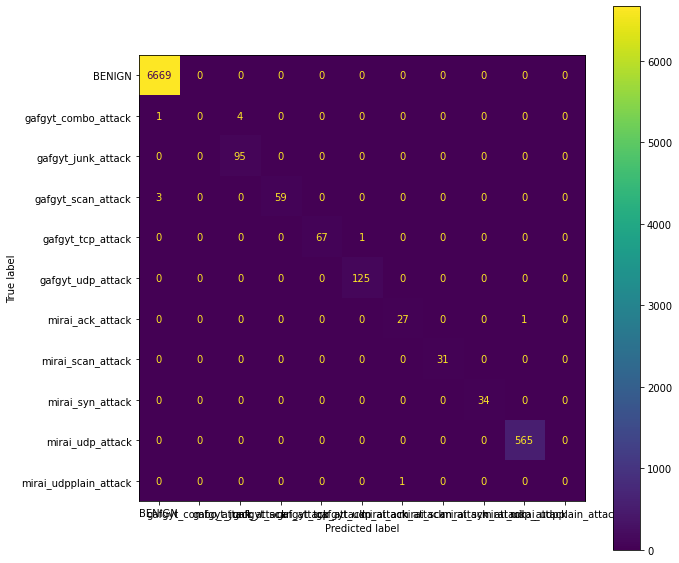

In [ ]:
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
print(cm)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(cm ,display_labels=rf_clf.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
print(rf_clf.classes_)

['BENIGN' 'gafgyt_combo_attack' 'gafgyt_junk_attack' 'gafgyt_scan_attack'
 'gafgyt_tcp_attack' 'gafgyt_udp_attack' 'mirai_ack_attack'
 'mirai_scan_attack' 'mirai_syn_attack' 'mirai_udp_attack'
 'mirai_udpplain_attack']


# **Dynamic Solution**

## **Initial Data Preprocessing**

For the initial data preprocessing:

1. Drop the highly correlated columns.

2. One-hot encode categorical features.

In [ ]:
X.drop(labels=correlated_features, axis=1, inplace=True)

In [ ]:
objcols = X.select_dtypes(['object']).columns
print(objcols)

enc = OneHotEncoder(handle_unknown = 'ignore')

for obj in objcols:
    X[obj] = X[obj].astype('category')

X_cat = enc.fit_transform(X[list(objcols.values)]).toarray()

Index(['Source'], dtype='object')


In [ ]:
X_ = X.drop(labels=list(objcols.values), axis=1).to_numpy()
X = np.hstack((X_,X_cat))
print(X.shape)

(25609, 30)


## **Initial Training**

The model used is Random Forest classifier Initially, the model is trained on the static dataset.

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00     22287
  gafgyt_combo_attack       1.00      1.00      1.00        18
   gafgyt_junk_attack       1.00      1.00      1.00       377
   gafgyt_scan_attack       1.00      1.00      1.00       200
    gafgyt_tcp_attack       1.00      0.98      0.99       213
    gafgyt_udp_attack       0.99      1.00      0.99       446
     mirai_ack_attack       1.00      1.00      1.00        96
    mirai_scan_attack       1.00      1.00      1.00        86
     mirai_syn_attack       1.00      1.00      1.00       101
     mirai_udp_attack       1.00      1.00      1.00      1774
mirai_udpplain_attack       1.00      1.00      1.00        11

             accuracy                           1.00     25609
            macro avg       1.00      1.00      1.00     25609
         weighted avg       1.00      1.00      1.00     25609

[[22287     0     0     0     0     0     0     0   

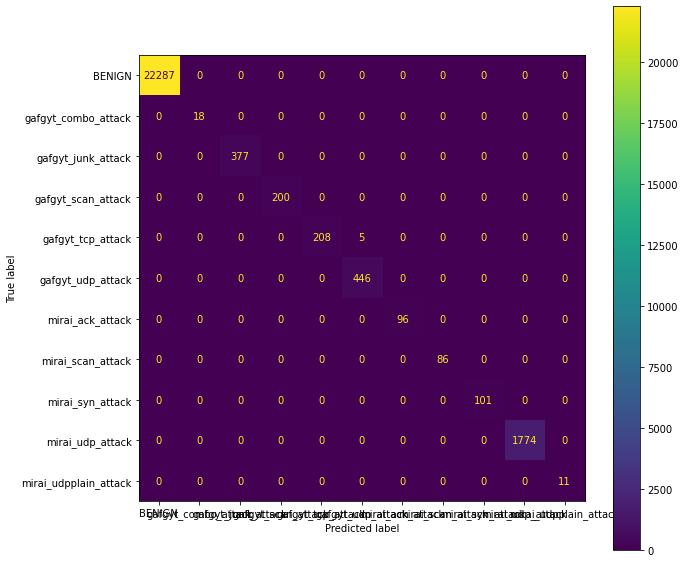

In [ ]:
rf_clf_dyn = RandomForestClassifier(random_state=0)
rf_clf_dyn.fit(X, y)
y_pred = rf_clf_dyn.predict(X)
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred, labels=rf_clf_dyn.classes_)
print(cm)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(cm ,display_labels=rf_clf_dyn.classes_)
disp.plot(ax=ax)
plt.show()

## **Updated Training and Testing**

1. Data preprocessing is applied to each received packet.

2. The preprocessed packet is then passed to the model to predict the label.

3. In each iteration, the predictions are stored to be later used for evaluation.

4. After every 1000 packets, the train data will be updated by removing the first 1000 rows and adding the newly recieved 1000 packets.

5. The number of iterations is 100, which means that, in total, 100000 packets are recieved.

In [ ]:
X_update = X
y_update = y
f1_scores = []
acc_scores = []
f1_scores_dyn = []
acc_scores_dyn = []

Ben = []  #BENIGN
gca = []  #gafgyt_combo_attack
gja = []  #gafgyt_junk_attack
gsa = []  #gafgyt_scan_attack
gta = []  #gafgyt_tcp_attack
gua = []  #gafgyt_udp_attack
maa = []  #mirai_ack_attack
msa = []  #mirai_scan_attack
msya = [] #mirai_syn_attack
mus = []  #mirai_udp_attack
mupa = [] #mirai_udpplain_attack
#imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task2',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

for k in range(100):  

  # Data Stream flowing in.
  i = 0
  X_new = []
  y_new = pd.Series([], dtype=str)
  y_pred = []
  y_pred_dyn = []
  #imp_med.fit(X_update)
  print(f"Iteration {k+1}:")
  Ben.append(y_update.value_counts().BENIGN)
  gca.append(y_update.value_counts().gafgyt_combo_attack)
  gja.append(y_update.value_counts().gafgyt_junk_attack)
  gsa.append(y_update.value_counts().gafgyt_scan_attack)
  gta.append(y_update.value_counts().gafgyt_tcp_attack)
  gua.append(y_update.value_counts().gafgyt_udp_attack)
  maa.append(y_update.value_counts().mirai_ack_attack)
  msa.append(y_update.value_counts().mirai_scan_attack)
  msya.append(y_update.value_counts().mirai_syn_attack)
  mus.append(y_update.value_counts().mirai_udp_attack)
  mupa.append(y_update.value_counts().mirai_udpplain_attack)
  for message in consumer:
      print(f"Consuming the {i+1}th data packet!")
      
      data_packet = message.value
      #print(data_packet)
      packet_dict = eval(data_packet.decode("UTF-8"))
      packet_df = pd.DataFrame(packet_dict, index=[0,])
      x = packet_df.drop(columns=['Class'])
      yp = packet_df['Class']
      x.drop(labels=correlated_features, axis=1, inplace=True)
      x_cat = enc.transform(x[list(objcols.values)]).toarray()
      x_ = x.drop(labels=list(objcols.values), axis=1).to_numpy()
      x = np.hstack((x_,x_cat))
      if i==0:
        X_new = x
      else:
        X_new = np.vstack((X_new,x))
      y_new = y_new.append(yp, ignore_index=True)
      packet_pred = rf_clf.predict(x)
      packet_pred_dyn = rf_clf_dyn.predict(x)
      #print(f'Predicted label of packet {i+1} is {packet_pred}')
      #print(f'True label of packet {i+1} is {yp.values}')
      y_pred = np.append(y_pred, packet_pred)  
      y_pred_dyn = np.append(y_pred_dyn, packet_pred_dyn)      

      i+=1
      if i == 1000:
          break
  f1_scores = np.append(f1_scores, f1_score(y_new, y_pred, average='macro'))
  acc_scores = np.append(acc_scores, accuracy_score(y_new, y_pred))
  f1_scores_dyn = np.append(f1_scores_dyn, f1_score(y_new, y_pred_dyn, average='macro'))
  acc_scores_dyn = np.append(acc_scores_dyn, accuracy_score(y_new, y_pred_dyn))
  X_update = np.delete(X_update, (range(1000)), axis=0)
  X_update = np.vstack((X_update, X_new))
  y_update = y_update.iloc[1000:,]
  y_update = y_update.append(y_new, ignore_index=True)
  
  rf_clf_dyn.fit(X_update, y_update)


Streaming output truncated to the last 5000 lines.
Consuming the 5th data packet!
Consuming the 6th data packet!
Consuming the 7th data packet!
Consuming the 8th data packet!
Consuming the 9th data packet!
Consuming the 10th data packet!
Consuming the 11th data packet!
Consuming the 12th data packet!
Consuming the 13th data packet!
Consuming the 14th data packet!
Consuming the 15th data packet!
Consuming the 16th data packet!
Consuming the 17th data packet!
Consuming the 18th data packet!
Consuming the 19th data packet!
Consuming the 20th data packet!
Consuming the 21th data packet!
Consuming the 22th data packet!
Consuming the 23th data packet!
Consuming the 24th data packet!
Consuming the 25th data packet!
Consuming the 26th data packet!
Consuming the 27th data packet!
Consuming the 28th data packet!
Consuming the 29th data packet!
Consuming the 30th data packet!
Consuming the 31th data packet!
Consuming the 32th data packet!
Consuming the 33th data packet!
Consuming the 34th data pa

In [ ]:
f1_scores==f1_scores_dyn

array([ True,  True, False,  True,  True, False, False,  True, False,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False,  True, False,
        True, False,  True, False,  True, False, False, False, False,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True, False, False,
        True])

In [ ]:
np.unique(y_pred)

array(['BENIGN', 'gafgyt_junk_attack', 'gafgyt_scan_attack',
       'gafgyt_tcp_attack', 'gafgyt_udp_attack', 'mirai_ack_attack',
       'mirai_scan_attack', 'mirai_syn_attack', 'mirai_udp_attack'],
      dtype=object)

## **Evaluation**

Evalute the model's performance in each iteration. During each iteration, 1000 data packets are tested.

Plot f1 score for each iteration.

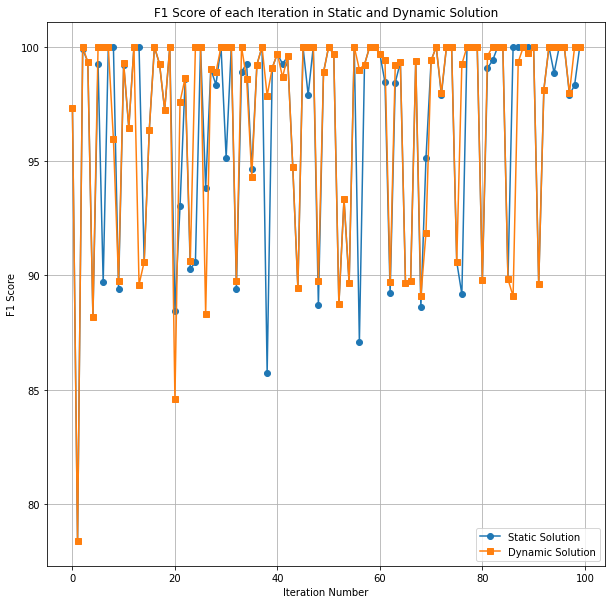

In [ ]:
plt.figure(figsize=(10, 10))
x_ax = range(100)
plt.plot(f1_scores *100, marker = 'o', label = "Static Solution")
plt.plot(f1_scores_dyn*100, marker = 's', label = "Dynamic Solution")
#plt.plot(x_ax, f1_scores, label="Static Solution")
#plt.plot(x_ax, f1_scores_dyn, label="Dynamic Solution")
plt.xlabel("Iteration Number")
plt.ylabel("F1 Score")
plt.title('F1 Score of each Iteration in Static and Dynamic Solution')
#plt.ylim([99.4, 100])
#plt.yticks(np.arange(min(f1_scores*100), max(f1_scores*100), 0.05))
plt.grid()
plt.legend()
plt.show()

Plot accuracy of each iteration

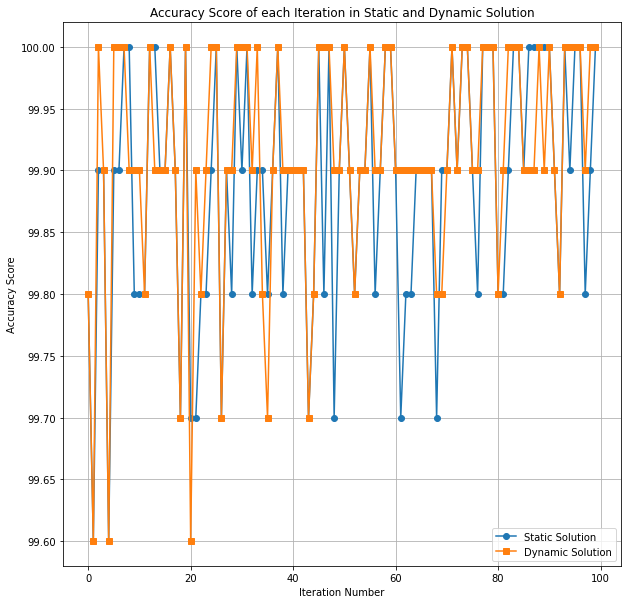

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(range(100), acc_scores*100, marker = 'o', label = "Static Solution")
plt.plot(range(100), acc_scores_dyn*100, marker = 's', label = "Dynamic Solution")
plt.xlabel("Iteration Number")
plt.ylabel("Accuracy Score")
plt.title('Accuracy Score of each Iteration in Static and Dynamic Solution')
#plt.yticks(np.arange(min(acc_scores*100), max(acc_scores*100), 0.05))
plt.legend()
plt.grid()
plt.show()

Plot the labels distribution in the updated train dataset of each iteration.

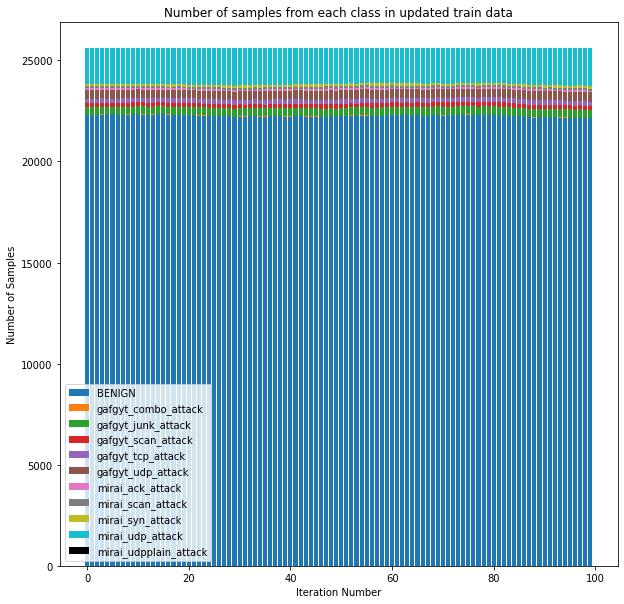

In [ ]:
#[Ben, gca, gja, gsa, gta, gua, maa, msa, msya, mus, mupa]
Ben = np.array(Ben)
gca = np.array(gca)
gja = np.array(gja)
gsa = np.array(gsa)
gta = np.array(gta)
gua = np.array(gua)
maa = np.array(maa)
msa = np.array(msa)
msya = np.array(msya)
mus = np.array(mus)
mupa = np.array(mupa)
Labels = ['BENIGN', 'gafgyt_combo_attack', 'gafgyt_junk_attack', 'gafgyt_scan_attack',
          'gafgyt_tcp_attack', 'gafgyt_udp_attack', 'mirai_ack_attack',
          'mirai_scan_attack', 'mirai_syn_attack', 'mirai_udp_attack',
          'mirai_udpplain_attack']
plt.figure(figsize=(10, 10))
X_axis = np.arange(100)
#plt.xticks(X_axis)
#plt.yticks(np.arange(0 , max(Ben)+max(gca)+max(gja)+max(gsa)+max(gta)+max(gua)+max(maa)+max(msa)+max(msya)+max(mus)+max(mupa)+500, 500))
plt.bar(X_axis, Ben, color='#1f77b4')
plt.bar(X_axis, gca, bottom=Ben, color='#ff7f0e')
plt.bar(X_axis, gja, bottom=Ben+gca, color='#2ca02c')
plt.bar(X_axis, gsa, bottom=Ben+gca+gja, color='#d62728')
plt.bar(X_axis, gta, bottom=Ben+gca+gja+gsa, color='#9467bd')
plt.bar(X_axis, gua, bottom=Ben+gca+gja+gsa+gta, color='#8c564b')
plt.bar(X_axis, maa, bottom=Ben+gca+gja+gsa+gta+gua, color='#e377c2')
plt.bar(X_axis, msa, bottom=Ben+gca+gja+gsa+gta+gua+maa, color='#7f7f7f')
plt.bar(X_axis, msya, bottom=Ben+gca+gja+gsa+gta+gua+maa+msa, color='#bcbd22')
plt.bar(X_axis, mus, bottom=Ben+gca+gja+gsa+gta+gua+maa+msa+msya, color='#17becf')
plt.bar(X_axis, mupa, bottom=Ben+gca+gja+gsa+gta+gua+maa+msa+msya+mus, color='#000000')
plt.xlabel("Iteration Number")
plt.ylabel("Number of Samples")
plt.title('Number of samples from each class in updated train data')
plt.legend(Labels)
plt.show()